In [36]:
import os
import kagglehub
import pandas as pd
import xgboost as xgb
import shap
import lime
import lime.lime_tabular

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


1. Let us see some deep learning models and how they can be explained 
2. Your turn: 
    1. Train at least two advanced models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size 
    2. Explain the patterns the model has learned using SHAP local and global plots 
    3. Explain the patterns using LIME 
    4. Compare the answers from LIME & SHAP (global & some local) – what do you see? Is it the same?

In [37]:
# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Path to dataset files: /Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


In [38]:
dataset_path = "/Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3"

files = os.listdir(dataset_path)
print(files)


['est_hourly.paruqet', 'PJMW_hourly.csv', 'pjm_hourly_est.csv', 'PJM_Load_hourly.csv', 'DAYTON_hourly.csv', 'NI_hourly.csv', 'PJME_hourly.csv', 'FE_hourly.csv', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DEOK_hourly.csv', 'DUQ_hourly.csv', 'AEP_hourly.csv', 'COMED_hourly.csv']


In [39]:
file_path = "/Users/marek/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3/PJME_hourly.csv"

In [40]:
df = pd.read_csv(file_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()



In [41]:
df5y = df[df.index >= '08-01-2013']

def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['PJME_MW'].shift(1)   # 1 day lag
    df['lag_1w'] = df['PJME_MW'].shift(7)   # 1 week lag
    df['lag_1m'] = df['PJME_MW'].shift(30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['PJME_MW'].shift(365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3d'] = df['PJME_MW'].rolling(window=3).mean()  # Last 3 days rolling mean
    df['rolling_mean_30d'] = df['PJME_MW'].rolling(window=30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['PJME_MW'].shift(365).rolling(window=30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['PJME_MW'].shift(365).rolling(window=7).mean()  # Same week previous year rolling mean

    return df

df5y = create_features(df5y)

df5y

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1d,lag_1w,lag_1m,lag_1y,rolling_mean_3d,rolling_mean_30d,rolling_mean_same_month_last_year,rolling_mean_same_week_last_year
Datetime,,,,,,,,,,,,,,,,,
2013-08-01 00:00:00,31988.0,0,3,3,8,2013,213,1,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 01:00:00,29509.0,1,3,3,8,2013,213,1,31,31988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-01 02:00:00,27883.0,2,3,3,8,2013,213,1,31,29509.0,NaN,NaN,NaN,29793.333333,NaN,NaN,NaN
2013-08-01 03:00:00,26792.0,3,3,3,8,2013,213,1,31,27883.0,NaN,NaN,NaN,28061.333333,NaN,NaN,NaN
2013-08-01 04:00:00,26260.0,4,3,3,8,2013,213,1,31,26792.0,NaN,NaN,NaN,26978.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,45641.0,45372.0,45313.0,42771.0,45486.000000,41515.666667,38934.233333,38711.142857
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,44057.0,46534.0,46430.0,43742.0,44318.000000,41409.866667,38948.666667,40083.428571
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,43256.0,47154.0,47867.0,44607.0,42955.000000,41199.366667,38906.000000,41346.428571


In [42]:
FEATURES = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]
TARGET = 'PJME_MW'

X = df5y[FEATURES]
y = df5y[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [43]:
import numpy as np

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

 99%|===================| 8660/8775 [00:28<00:00]        

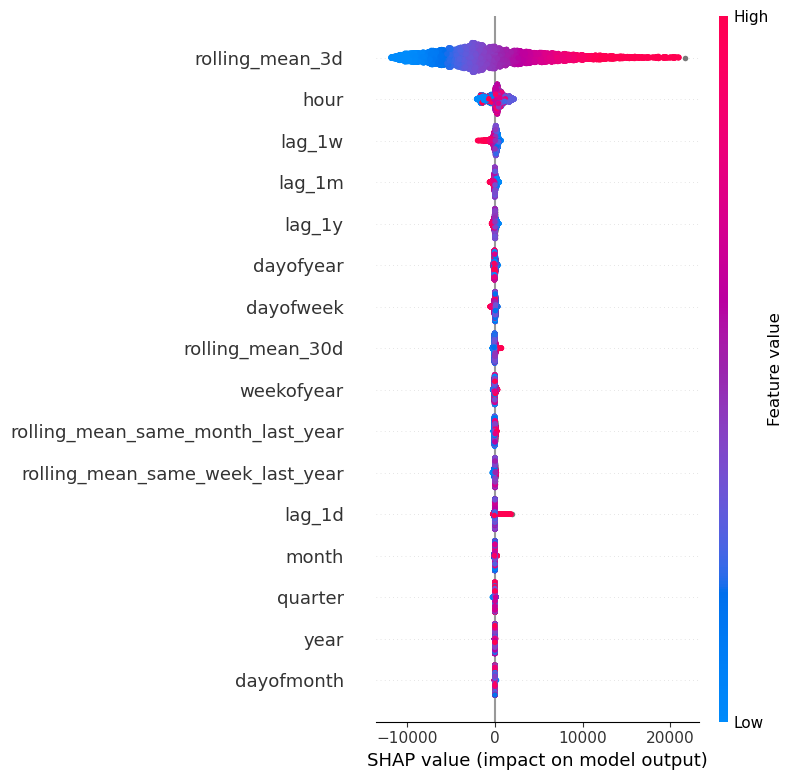

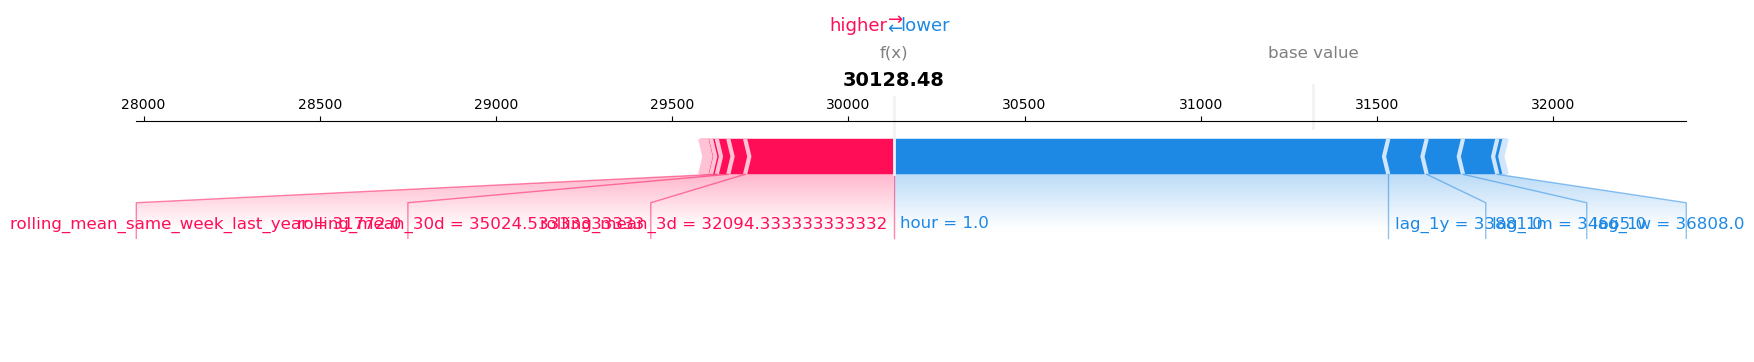

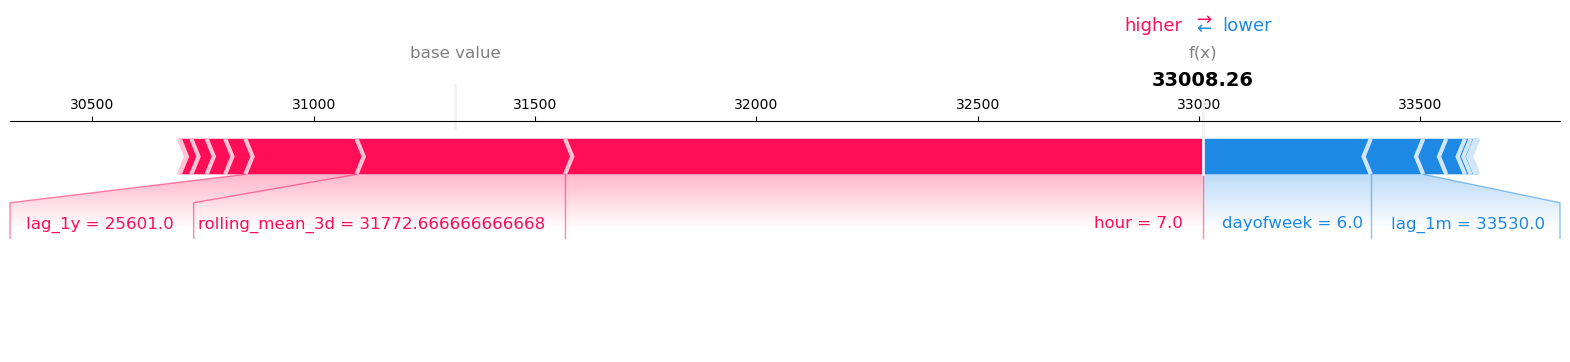

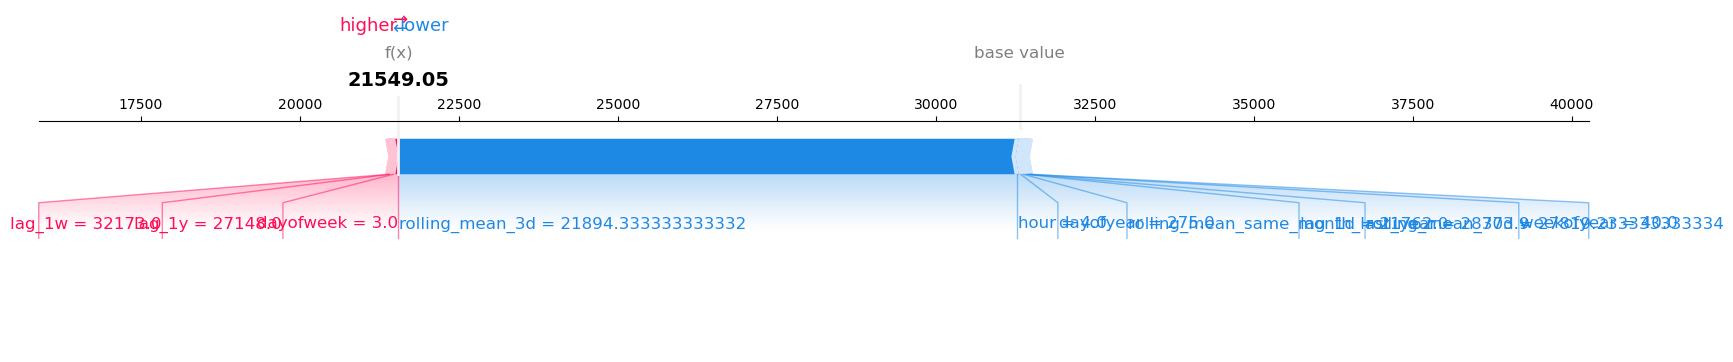

In [44]:
# SHAP explanation for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train.astype(float))
shap_values_xgb = explainer_xgb(X_test)

# SHAP summary plot (Global explanation)
shap.summary_plot(shap_values_xgb, X_test)

# SHAP force plot for local explanation (first instance)
shap.initjs()

# SHAP force plots for local explanations (first three instances)
for i in range(3):
    shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[i].values, X_test.iloc[i,:], matplotlib=True)


In [45]:
# Standardize the data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for NaN values in the training data

contains_nan_train = np.any(np.isnan(X_train_scaled))

contains_nan_test = np.any(np.isnan(X_test_scaled))

# Handle NaN values if present

if contains_nan_train or contains_nan_test:
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output layer
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_test_scaled, y_test))

Epoch 1/10
2194/2194 [==============================] - 1s 492us/step - loss: 380366848.0000 - val_loss: 64237820.0000
Epoch 2/10
2194/2194 [==============================] - 1s 455us/step - loss: 39163180.0000 - val_loss: 19817270.0000
Epoch 3/10
2194/2194 [==============================] - 1s 455us/step - loss: 10272121.0000 - val_loss: 4589346.5000
Epoch 4/10
2194/2194 [==============================] - 1s 453us/step - loss: 2683136.7500 - val_loss: 1608527.8750
Epoch 5/10
2194/2194 [==============================] - 1s 454us/step - loss: 1213257.8750 - val_loss: 1003945.1250
Epoch 6/10
2194/2194 [==============================] - 1s 455us/step - loss: 897305.4375 - val_loss: 857743.8750
Epoch 7/10
2194/2194 [==============================] - 1s 457us/step - loss: 802439.9375 - val_loss: 794657.8125
Epoch 8/10
2194/2194 [==============================] - 1s 456us/step - loss: 755936.2500 - val_loss: 756335.6875
Epoch 9/10
2194/2194 [==============================] - 1s 453us/step - 

PermutationExplainer explainer: 8776it [04:11, 33.60it/s]                          


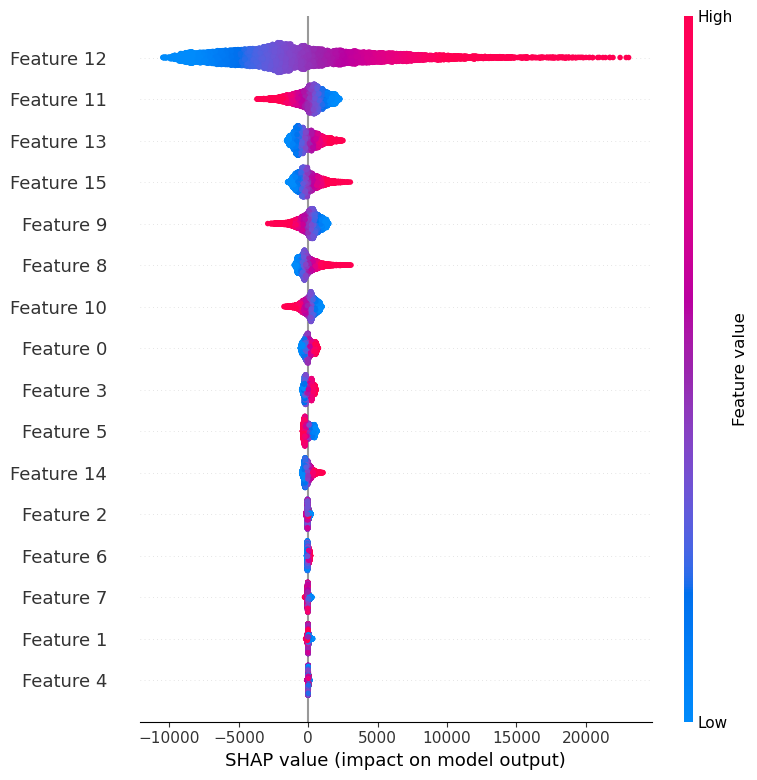

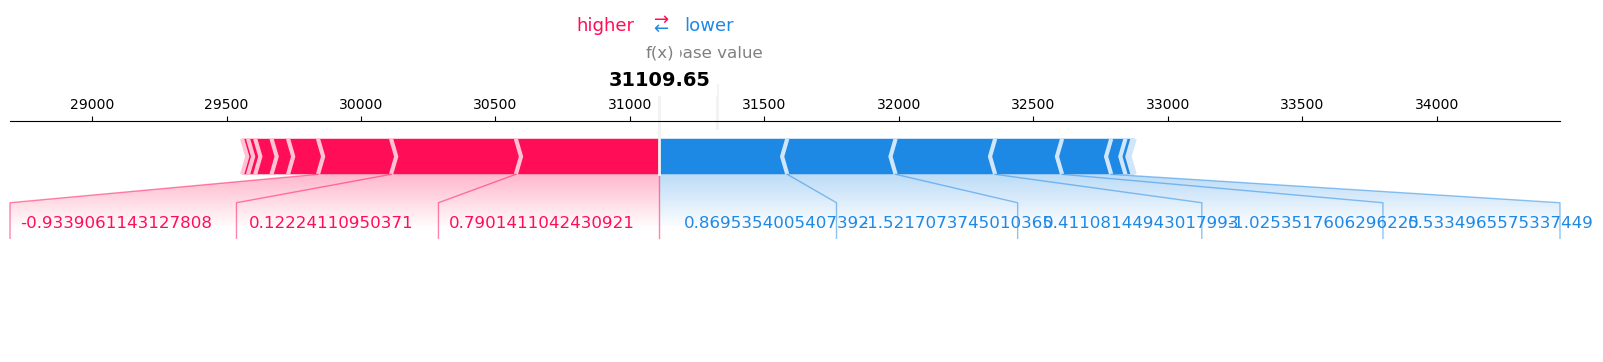

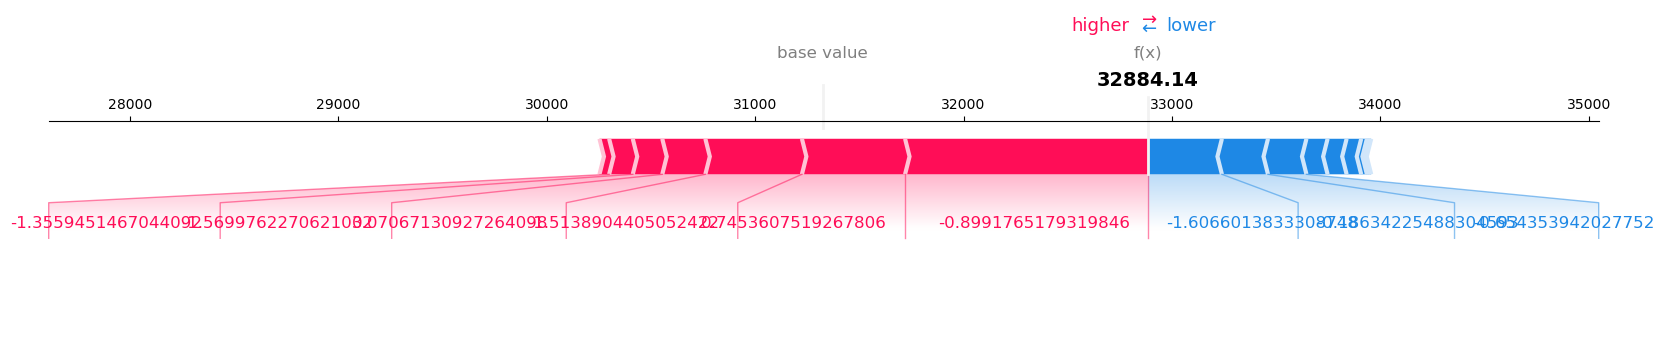

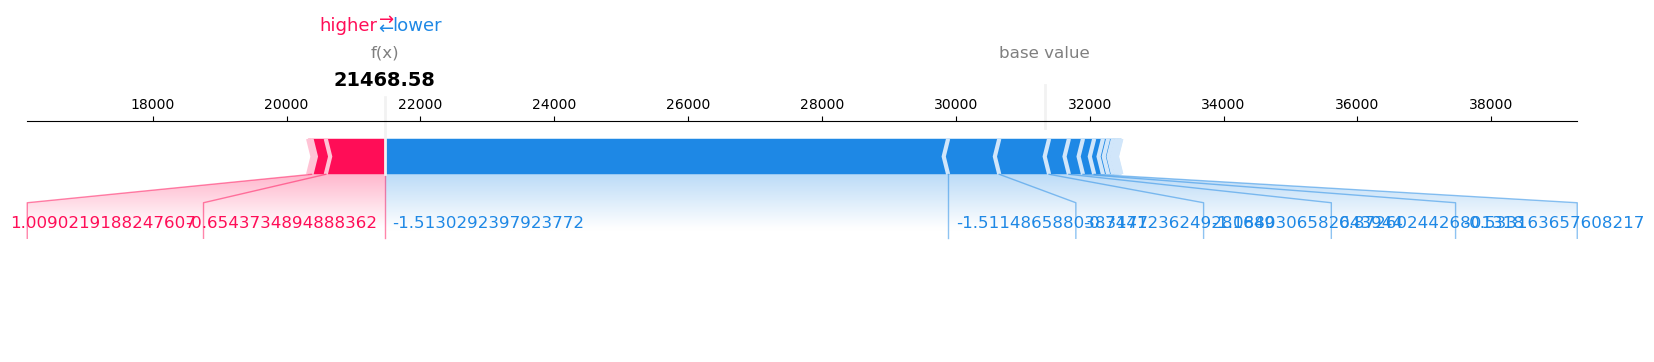

In [46]:
# SHAP explanation for Neural Network
explainer_nn = shap.Explainer(model, X_train_scaled)
shap_values_nn = explainer_nn(X_test_scaled)

# SHAP summary plot for Neural Network
shap.summary_plot(shap_values_nn, X_test_scaled)

# SHAP force plots for local explanations (first three instances)
for i in range(3):
    shap.force_plot(shap_values_nn.base_values[i], shap_values_nn.values[i], X_test_scaled[i], matplotlib=True)

LIME explanations for XGBoost model:

Explanation for instance 0:
Actual value: 30351.0
Predicted value: 30128.47
Top features:
  dayofweek > 1.00: -62.6533
  hour > 0.94: -49.7991
  year > 0.94: 26.3658
  month > 1.01: 21.4965
  lag_1m > 0.58: 16.4407
  lag_1d > 0.58: 15.6604

Explanation for instance 10:
Actual value: 29449.0
Predicted value: 29793.72
Top features:
  dayofweek > 1.00: -67.0068
  hour > 0.94: -49.9511
  year > 0.94: 30.3453
  month > 1.01: 20.8163
  dayofmonth > 0.83: 15.7062
  rolling_mean_same_week_last_year > 0.57: 14.6113

Explanation for instance 20:
Actual value: 21682.0
Predicted value: 21616.29
Top features:
  quarter > 1.34: 602.1556
  dayofweek > 1.00: -88.0020
  hour > 0.94: -66.9915
  year > 0.94: 1.1374
  rolling_mean_30d > 0.66: 0.2597
  rolling_mean_same_week_last_year > 0.57: 0.1419


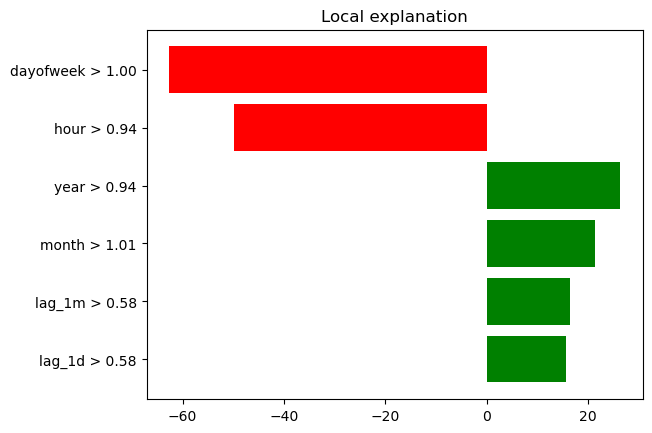

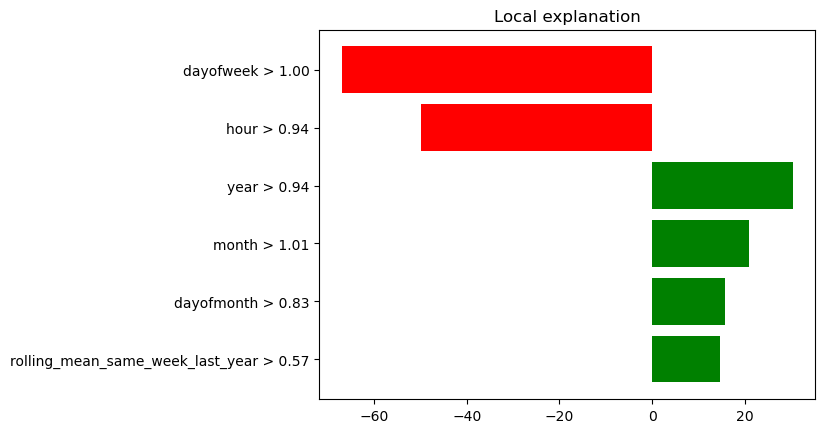

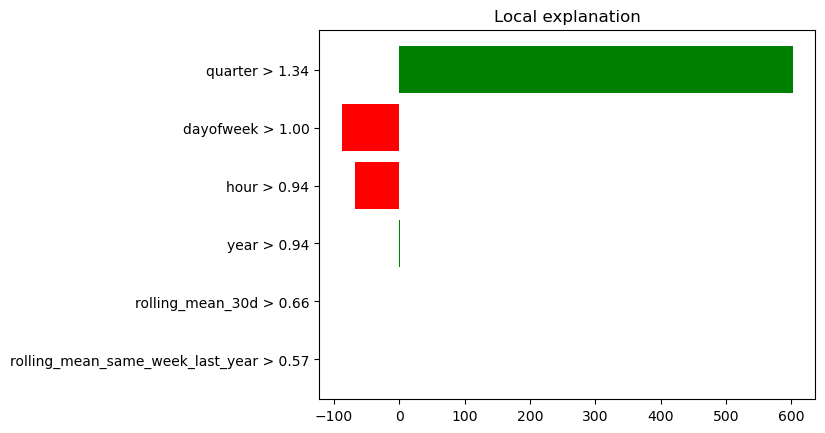

In [53]:
# Create a LimeTabularExplainer for the XGBoost model
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=FEATURES,
    class_names=['Energy Consumption (MW)'],
    mode='regression'
)

# Select a few sample instances to explain
sample_indices = [0, 10, 20]  # Let's explain the first, 10th, and 20th instances

# Explain XGBoost predictions
print("LIME explanations for XGBoost model:")
for idx in sample_indices:
    exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values, 
        xgb_model.predict, 
        num_features=6
    )
    print(f"\nExplanation for instance {idx}:")
    print(f"Actual value: {y_test.iloc[idx]}")
    print(f"Predicted value: {xgb_model.predict([X_test.iloc[idx].values])[0]:.2f}")
    print("Top features:")
    for feature, importance in exp.as_list():
        print(f"  {feature}: {importance:.4f}")
    
    # Display the explanation as a plot
    exp.as_pyplot_figure()
 


LIME explanations for Neural Network model:
113/157 [====================>.........] - ETA: 0s

/Users/marek/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


157/157 [==============================] - 0s 1ms/step

Explanation for instance 0:
Actual value: 30351.0
1/1 [==============================] - 0s 23ms/step
Predicted value: 31109.65
Top features:
  year > 0.94: -8448.6423
  dayofweek > 1.00: -5857.9376
  month > 1.01: -5054.8699
  dayofmonth > 0.83: -3477.0505
  rolling_mean_3d > 0.58: -3397.9807
  rolling_mean_same_week_last_year > 0.57: -3352.5656
155/157 [============================>.] - ETA: 0s

/Users/marek/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


157/157 [==============================] - 0s 989us/step

Explanation for instance 10:
Actual value: 29449.0
1/1 [==============================] - 0s 12ms/step
Predicted value: 31058.08
Top features:
  year > 0.94: -8349.2383
  dayofweek > 1.00: -4978.3848
  month > 1.01: -4826.1558
  hour > 0.94: -3909.9896
  weekofyear > 0.89: -3715.8620
  lag_1d > 0.58: -3400.6895
116/157 [=====================>........] - ETA: 0s

/Users/marek/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


157/157 [==============================] - 0s 1ms/step

Explanation for instance 20:
Actual value: 21682.0
1/1 [==============================] - 0s 19ms/step
Predicted value: 21515.06
Top features:
  quarter > 1.34: -1021834.2524
  year > 0.94: -5091.1860
  dayofweek > 1.00: -2778.0480
  month > 1.01: -2343.5172
  weekofyear > 0.89: -1661.4381
  rolling_mean_30d > 0.66: -1572.0562


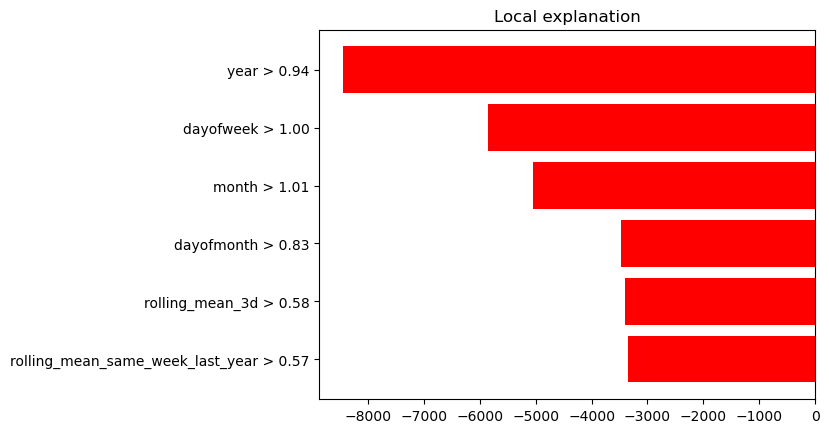

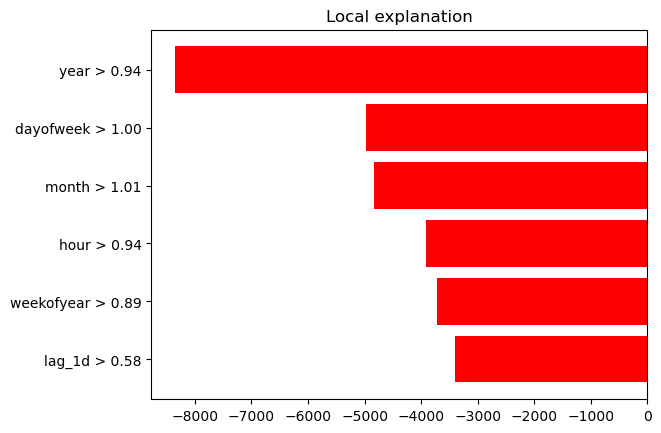

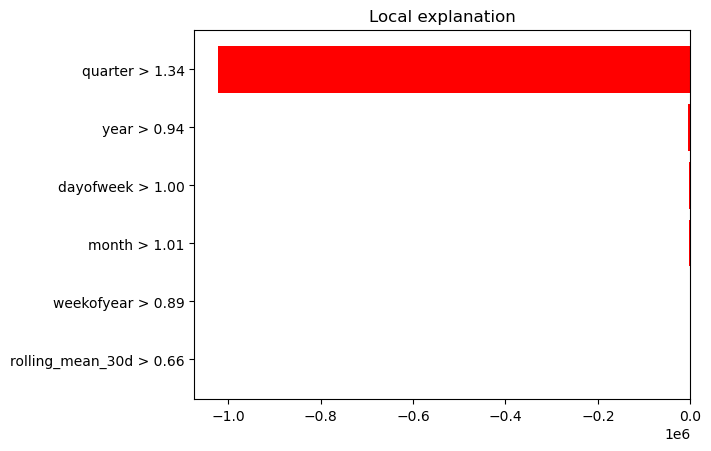

In [57]:
   
# Explain Neural Network predictions
print("\nLIME explanations for Neural Network model:")
for idx in sample_indices:
    exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values, 
        lambda x: model.predict(scaler.transform(x)).flatten(),
        num_features=6
    )
    print(f"\nExplanation for instance {idx}:")
    print(f"Actual value: {y_test.iloc[idx]}")
    print(f"Predicted value: {model.predict(X_test_scaled[idx].reshape(1, -1))[0][0]:.2f}")
    print("Top features:")
    for feature, importance in exp.as_list():
        print(f"  {feature}: {importance:.4f}")
    
    # Display the explanation as a plot
    exp.as_pyplot_figure()

In [55]:
# Compare LIME and SHAP explanations
print("\nComparison of SHAP and LIME explanations for XGBoost:")
for idx in sample_indices:
    print(f"\nInstance {idx}:")
    
    # Get SHAP values for this instance
    shap_values_instance = shap_values_xgb[idx]
    shap_feature_importance = list(zip(FEATURES, shap_values_instance.values))
    shap_feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Get LIME explanation for this instance
    lime_exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values, 
        xgb_model.predict, 
        num_features=len(FEATURES)
    )
    
    # Print top 5 important features from each
    print("Top 5 important features from SHAP:")
    for feature, importance in shap_feature_importance[:5]:
        print(f"  {feature}: {importance:.4f}")
    
    print("Top 5 important features from LIME:")
    for feature, importance in lime_exp.as_list()[:5]:
        print(f"  {feature}")


Comparison of SHAP and LIME explanations for XGBoost:

Instance 0:
Top 5 important features from SHAP:
  hour: -1403.5284
  rolling_mean_3d: 421.5610
  lag_1y: -109.0702
  lag_1m: -103.0134
  lag_1w: -97.4004
Top 5 important features from LIME:
  dayofweek > 1.00
  hour > 0.94
  year > 0.94
  month > 1.01
  rolling_mean_same_month_last_year > 0.65

Instance 10:
Top 5 important features from SHAP:
  rolling_mean_3d: -1896.3041
  hour: 359.4964
  lag_1w: 257.5412
  lag_1m: 209.8148
  rolling_mean_30d: -154.1562
Top 5 important features from LIME:
  dayofweek > 1.00
  hour > 0.94
  year > 0.94
  month > 1.01
  dayofyear > 0.86

Instance 20:
Top 5 important features from SHAP:
  rolling_mean_3d: -9119.7757
  hour: -501.3121
  dayofyear: -82.5604
  dayofweek: 65.8738
  lag_1w: 63.6665
Top 5 important features from LIME:
  quarter > 1.34
  dayofweek > 1.00
  hour > 0.94
  lag_1d > 0.58
  dayofmonth > 0.83
